# Classification using the Inception-ResNet-v2

This notebook is based on the code from Benjamin Wild, with modifications and additions.

First, we load the required dependencies and set the paths to the files.

In [1]:
# Config
import os
import sys
base_path = os.path.abspath(os.pardir)
sys.path.append(base_path)

data_path = base_path + '/data/model_data/train/'
val_data_path = base_path + '/data/model_data/val/'

In [2]:
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import keras.backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Dropout, Input, concatenate
from keras.models import Model, load_model
from keras.optimizers import Nadam
from scipy.ndimage.interpolation import rotate
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Monkey-patch keras DirectoryIterator to also return filename
import keras
from keras_util.util import DirectoryIteratorWithFname
keras.preprocessing.image.DirectoryIterator = DirectoryIteratorWithFname

---
## Data loading

We load the text file containing the labels used in ImageNet. Cheetahs and Leopards are already present there.

In [4]:
# Load and parse ImageNet class labels

#classes = open(base_path + '/modules/imagenet_classes', 'r').readlines()
classes = open('imagenet_classes', 'r').readlines()

def strip(c):
    key, value = c.split(':')
    key = key.strip()
    key = key.split('{')[-1]
    value = value.split("'")[1].strip()
    return int(key), value

classes = dict([strip(c) for c in classes])

In [5]:
izw_classes = ('unknown', 'cheetah', 'leopard')

---
We load the metadata (which contains the file paths) generated in the `split_data` notebook.

In [6]:
metadata = pd.read_hdf(base_path + '/data/model_data/metadata.hdf5')
val_metadata = metadata[metadata.set=='val'].copy()

# configure the batch size
batch_size = 32
small_batch_size = 4

train_size, val_size = sum(metadata.set=='train'), sum(metadata.set=='val')
train_pad, val_pad = train_size + (batch_size - (train_size % batch_size)), val_size + (batch_size - (val_size % batch_size))
train_pad_small, val_pad_small = train_size + (small_batch_size - (train_size % small_batch_size)), val_size + (small_batch_size - (val_size % small_batch_size))

print(train_size, val_size)
print(train_pad, val_pad, train_pad % batch_size, val_pad % batch_size)
print(train_pad_small, val_pad_small, train_pad_small % small_batch_size, val_pad_small % small_batch_size)

19875 2162
19904 2176 0 0
19876 2164 0 0


In [7]:
metadata.head()

ambient_temp  brightness  contrast            datetime  event1  event2  \
1156            14           0       160 2017-05-08 18:56:30       0     587   
857             14           0       160 2017-05-08 18:56:31       0     587   
1336            14           0       160 2017-05-08 18:56:32       0     587   
226             14           0       160 2017-05-08 18:56:34       0     588   
5               14           0       160 2017-05-08 18:56:35       0     588   

                filename  hour    label  \
1156  Leopard_000051.jpg    18  leopard   
857   Leopard_000052.jpg    18  leopard   
1336  Leopard_000053.jpg    18  leopard   
226   Leopard_000054.jpg    18  leopard   
5     Leopard_000055.jpg    18  leopard   

                                                   path  \
1156  /home/benjamin/Entwicklung/ComputerVision/Gepa...   
857   /home/benjamin/Entwicklung/ComputerVision/Gepa...   
1336  /home/benjamin/Entwicklung/ComputerVision/Gepa...   
226   /home/benjamin/Entwicklung/ComputerVision/Gepa...   
5     /home/benjamin/Entwicklung/ComputerVision/Gepa...   

                           ...                        sequence_max  \
1156                       ...                                   3   
857                        ...                                   3   
1336                       ...                                   3   
226                        ...                                   3   
5                          ...                                   3   

           serial_no    set sharpness             event_key_simple  \
1156  H600HG01173547  train        32  H600HG01173547_2017_128_587   
857   H600HG01173547  train        32  H600HG01173547_2017_128_587   
1336  H600HG01173547  train        32  H600HG01173547_2017_128_587   
226   H600HG01173547    val        32  H600HG01173547_2017_128_588   
5     H600HG01173547    val        32  H600HG01173547_2017_128_588   

                                             sortkey duplicates timeoffset  \
1156  H600HG01173547_2017_128_5871494269790000000000          0        NaT   
857   H600HG01173547_2017_128_5871494269791000000000          0   00:00:01   
1336  H600HG01173547_2017_128_5871494269792000000000          0   00:00:01   
226   H600HG01173547_2017_128_5881494269794000000000          0   00:00:02   
5     H600HG01173547_2017_128_5881494269795000000000          0   00:00:01   

                        event_key  \
1156  H600HG01173547_2017_128_587   
857   H600HG01173547_2017_128_587   
1336  H600HG01173547_2017_128_587   
226   H600HG01173547_2017_128_587   
5     H600HG01173547_2017_128_587   

                                            set_path  
1156  data/model_data/train/leopard/leopard_1156.jpg  
857    data/model_data/train/leopard/leopard_857.jpg  
1336  data/model_data/train/leopard/leopard_1336.jpg  
226      data/model_data/val/leopard/leopard_226.jpg  
5          data/model_data/val/leopard/leopard_5.jpg  

[5 rows x 22 columns]

---
The Keras image generators read the training and validation sets and supply a stream of image batches of the classes. (They infer the image classes from the directory names.)  
The training image iterator additionally augments the dataset by flipping images, the validation image iterator does not. 

Additionally there's a preprocessing generator wrapped around the iterator which augments the image input data with time/temperature metadata and additionally rotates images. 

In [8]:
# Crop camera metainformation from images

def preprocess(data, batch_size, rotate_range=None):
    for x, y, fns in data:
        batch_metadata = []
        for fname in fns:
            fname_splitted = fname.split('_')[1].split('.')
            
            index = fname_splitted[0]
            #rest = '_'.join(fname_splitted[1:]).split('.jpeg')[0]
            f_metadata = metadata.loc[int(index)]
            
            batch_metadata.append((
                f_metadata.ambient_temp,
                f_metadata.hour))
            # optionally use metadata
        temperatures = np.array(batch_metadata).astype(np.float32)
        x = x[:, 10:-10, 10:-10, :]
        if rotate_range is not None:
            for idx in range(batch_size):
                x[idx] = rotate(x[idx], np.random.random() * rotate_range * 2 - rotate_range, 
                                mode='reflect', reshape=False).astype(np.int64)
        yield [preprocess_input(x), temperatures], y

---
Because training the whole model with 32 image batches doesn't fit our 4GB GPU, we specifiy additional generators for batches of size 4.

The top layers can be trained with 32 size batches, but the finetuning only works on 4 image batches. Adjust if trained on a better GPU.

In [9]:
# Augment train data with horizontal flips, scale to ImageNet input size

generator = ImageDataGenerator(horizontal_flip=True)
val_generator = ImageDataGenerator(horizontal_flip=False)

train_gen = preprocess(generator.flow_from_directory(
    data_path, 
    target_size=(299+20, 299+20),
    classes=izw_classes,
    batch_size=batch_size), batch_size, rotate_range=10)

val_gen = preprocess(val_generator.flow_from_directory(
    val_data_path, 
    target_size=(299+20, 299+20),
    classes=izw_classes,
    batch_size=batch_size), batch_size)

Found 19875 images belonging to 3 classes.
Found 2162 images belonging to 3 classes.


In [10]:
small_generator = ImageDataGenerator(horizontal_flip=True)
small_val_generator = ImageDataGenerator(horizontal_flip=False)

train_gen_small = preprocess(small_generator.flow_from_directory(
    data_path, 
    target_size=(299+20, 299+20),
    classes=izw_classes,
    batch_size=small_batch_size), small_batch_size, rotate_range=10)

val_gen_small = preprocess(small_val_generator.flow_from_directory(
    val_data_path, 
    target_size=(299+20, 299+20),
    classes=izw_classes,
    batch_size=small_batch_size), small_batch_size)

Found 19875 images belonging to 3 classes.
Found 2162 images belonging to 3 classes.


[0. 1. 0.]


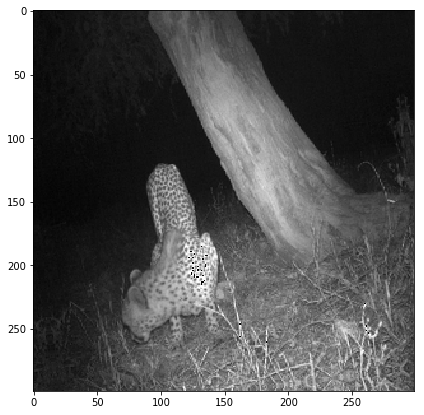

In [11]:
# Test data loader

[prec_in, temp], y = next(train_gen)

plt.figure(figsize=(7, 7))
plt.imshow(1 - ((prec_in[0] / 2) + .5) * 255, vmin=0, vmax=255)
print(y[0])

---
# Test pretrained model

To get a classification baseline of the neural net without finetuning, we just try to classify with some pictures.  
It generally works somewhat, but the NN has a harder job than necessary because the best estimates sometimes are labels we are not interested in.

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.001
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        s = '{:.3f}'.format(cm[i, j]) if normalize else cm[i,j]
        plt.text(j, i, s,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def label_confusion_matrix(val_labels, val_preds):
    cnf_matrix = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cnf_matrix, classes=izw_classes,
                          normalize=False, title='Confusion matrix')

In [13]:
# Load pretrained model
#
# http://arxiv.org/abs/1602.07261
#
# Inception-v4, Inception-ResNet and the Impact of Residual Connections
# on Learning
#
# Christian Szegedy, Sergey Ioffe, Vincent Vanhoucke, Alex Alemi

model = InceptionResNetV2()

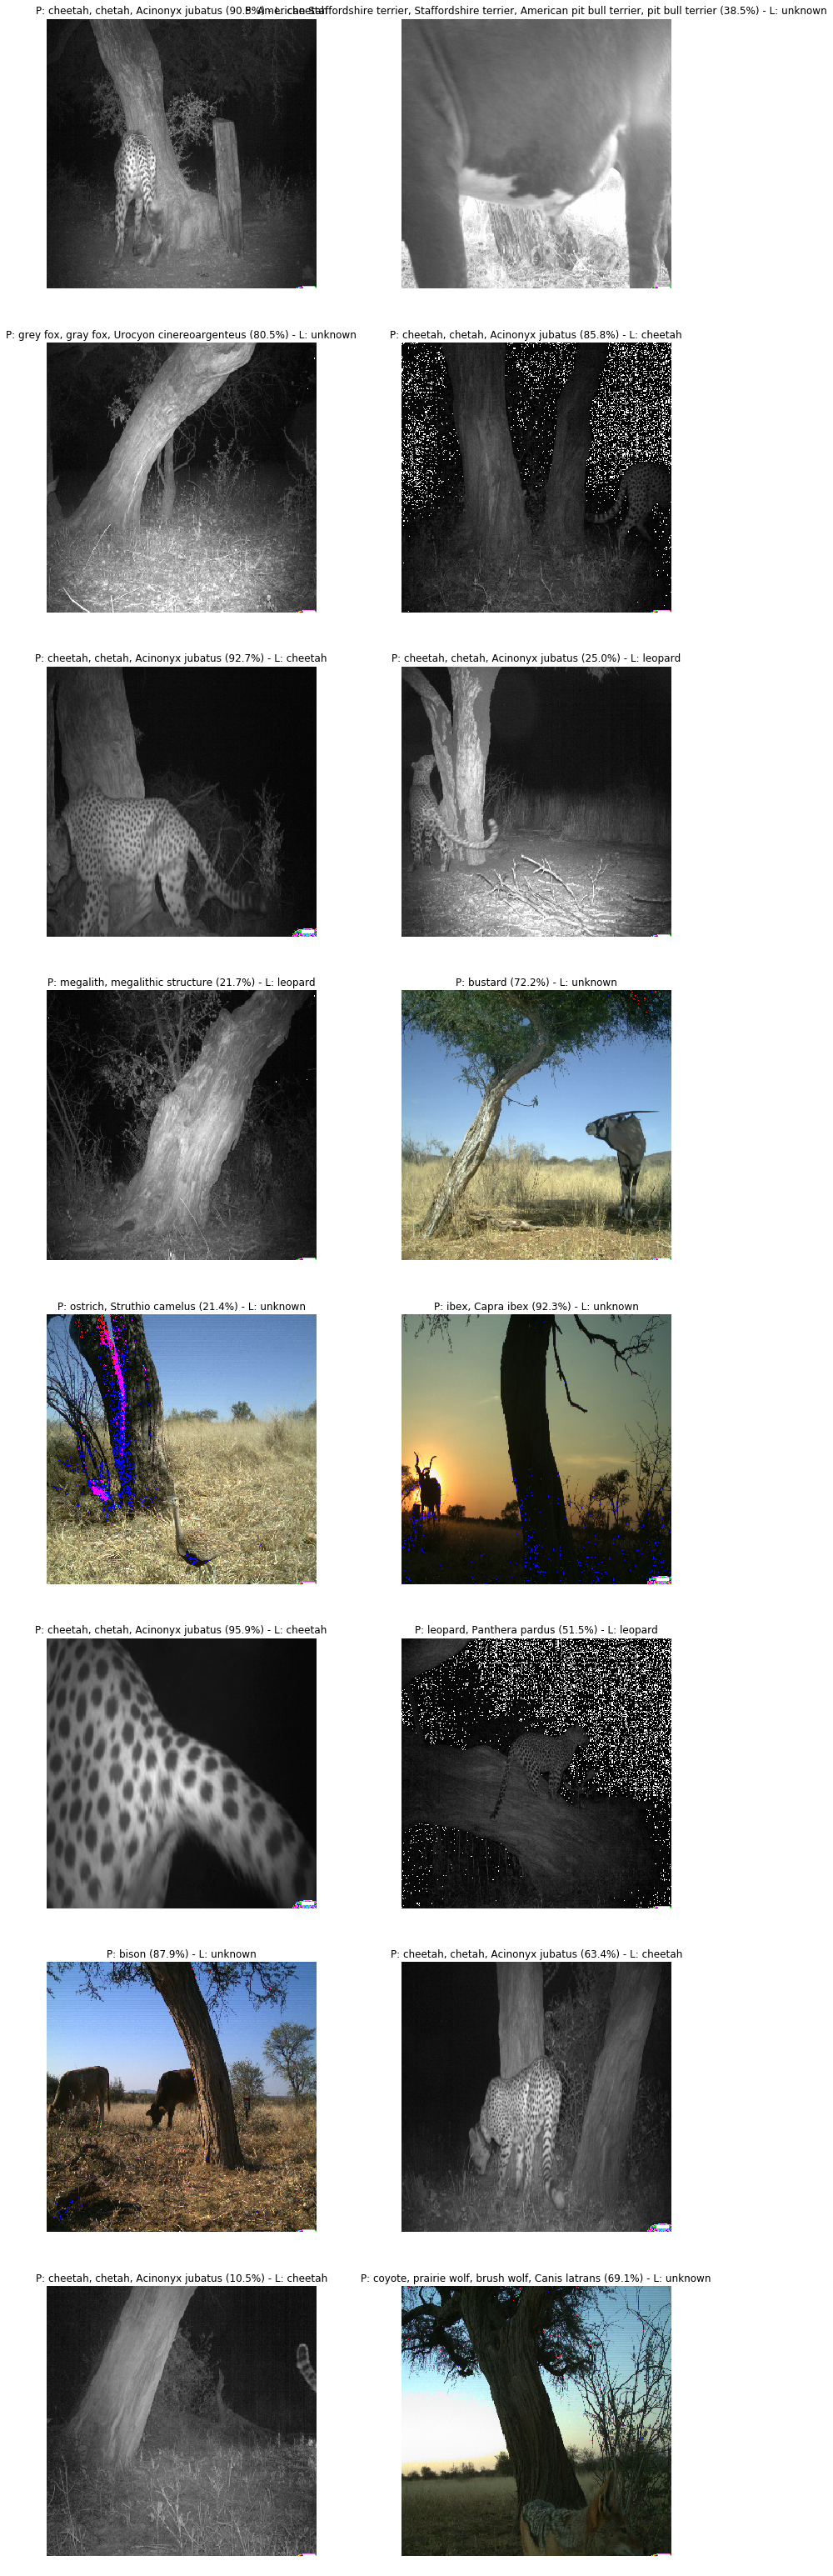

In [14]:
# Test pretrained model on IZW data

batch, true_labels = next(val_gen)
fig, axes = plt.subplots(8, 2, figsize=(14, (14 / 2) * 8))
for idx, (image, label, true_label) in enumerate(zip(batch[0][:16], model.predict(batch[0][:16]), true_labels[:16])):
    r, c = divmod(idx, 2)
    axes[r, c].imshow(1 - ((image / 2) + .5) * 255, vmin=0, vmax=255)
    axes[r, c].set_title('P: {} ({:.1f}%) - L: {}'.format(
        classes[label.argmax()],
        label[label.argmax()] * 100,
        izw_classes[true_label.argmax()]))
    axes[r, c].grid('off')
    axes[r, c].set_axis_off()

In [15]:
val_labels = []
val_preds = []

for idx, (batch, labels) in enumerate(val_gen):
    pred = model.predict(batch[0])
    for i in range(pred.shape[0]):    
        class_pred = classes[pred[i,:].argmax()]
        class_pred = np.where([x in class_pred for x in izw_classes])
        class_pred = 0 if class_pred[0].size==0 else class_pred[0][0]
        
        val_preds.append(class_pred)
        val_labels.append(labels[i].argmax())
    
    if idx == (val_size // batch_size):
        break

Accuracy: 76.364%

             precision    recall  f1-score   support

    unknown       0.57      1.00      0.73       542
    cheetah       0.96      0.71      0.82      1479
    leopard       0.47      0.41      0.44       141

avg / total       0.83      0.76      0.77      2162



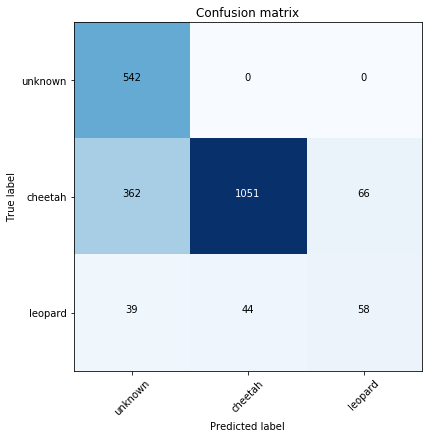

In [16]:
print('Accuracy: {:.3f}%\n'.format(accuracy_score(val_labels, val_preds) * 100))
print(classification_report(val_labels, val_preds, target_names=izw_classes))

label_confusion_matrix(val_labels, val_preds)

---
# Model definition and finetuning

First we define the model: Based on the InceptionResnetV2, we remove its last fully connected layer.  
A new final layer is added that takes the previous hidden layer output and the metadata information. Dropout is used for regularization. 

We only have a 3-class softmax output for the Cheetah, Leopard and Unknown classes.

In [17]:
# Use pretrained model, but skip last (classifier) layer and replace it with a new layer for the three IZW classes
# Fix pretrained layers, only learn last weights for last layer
# Also use metadata as additional input

metadata_input = Input(shape=(2, ))

base_model = InceptionResNetV2(include_top=False, pooling='avg')
h = concatenate([base_model.output, metadata_input])
h = Dropout(.2, name='Dropout')(h)
outputs = Dense(3, activation='softmax')(h)

for layer in base_model.layers:
    layer.trainable = False
    
model = Model(base_model.inputs + [metadata_input], outputs)

In [18]:
model.load_weights(base_path + '/data/model_data/inception-resnet-v2-cheetahs_weights.h5')
optim = Nadam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

---
Training the last layer is straightforward, but finetuning the whole model afterwards can be difficult since it requires a GPU with much memory.

Here we train the model, evaluate the results and store the weights and the model on disk.

The cells are currently deactivated unless we want to retrain.

---
# Evaluation

The model now seems to more reliably detect the labels we are interested in (it's easier to decide among three classes than 1000).

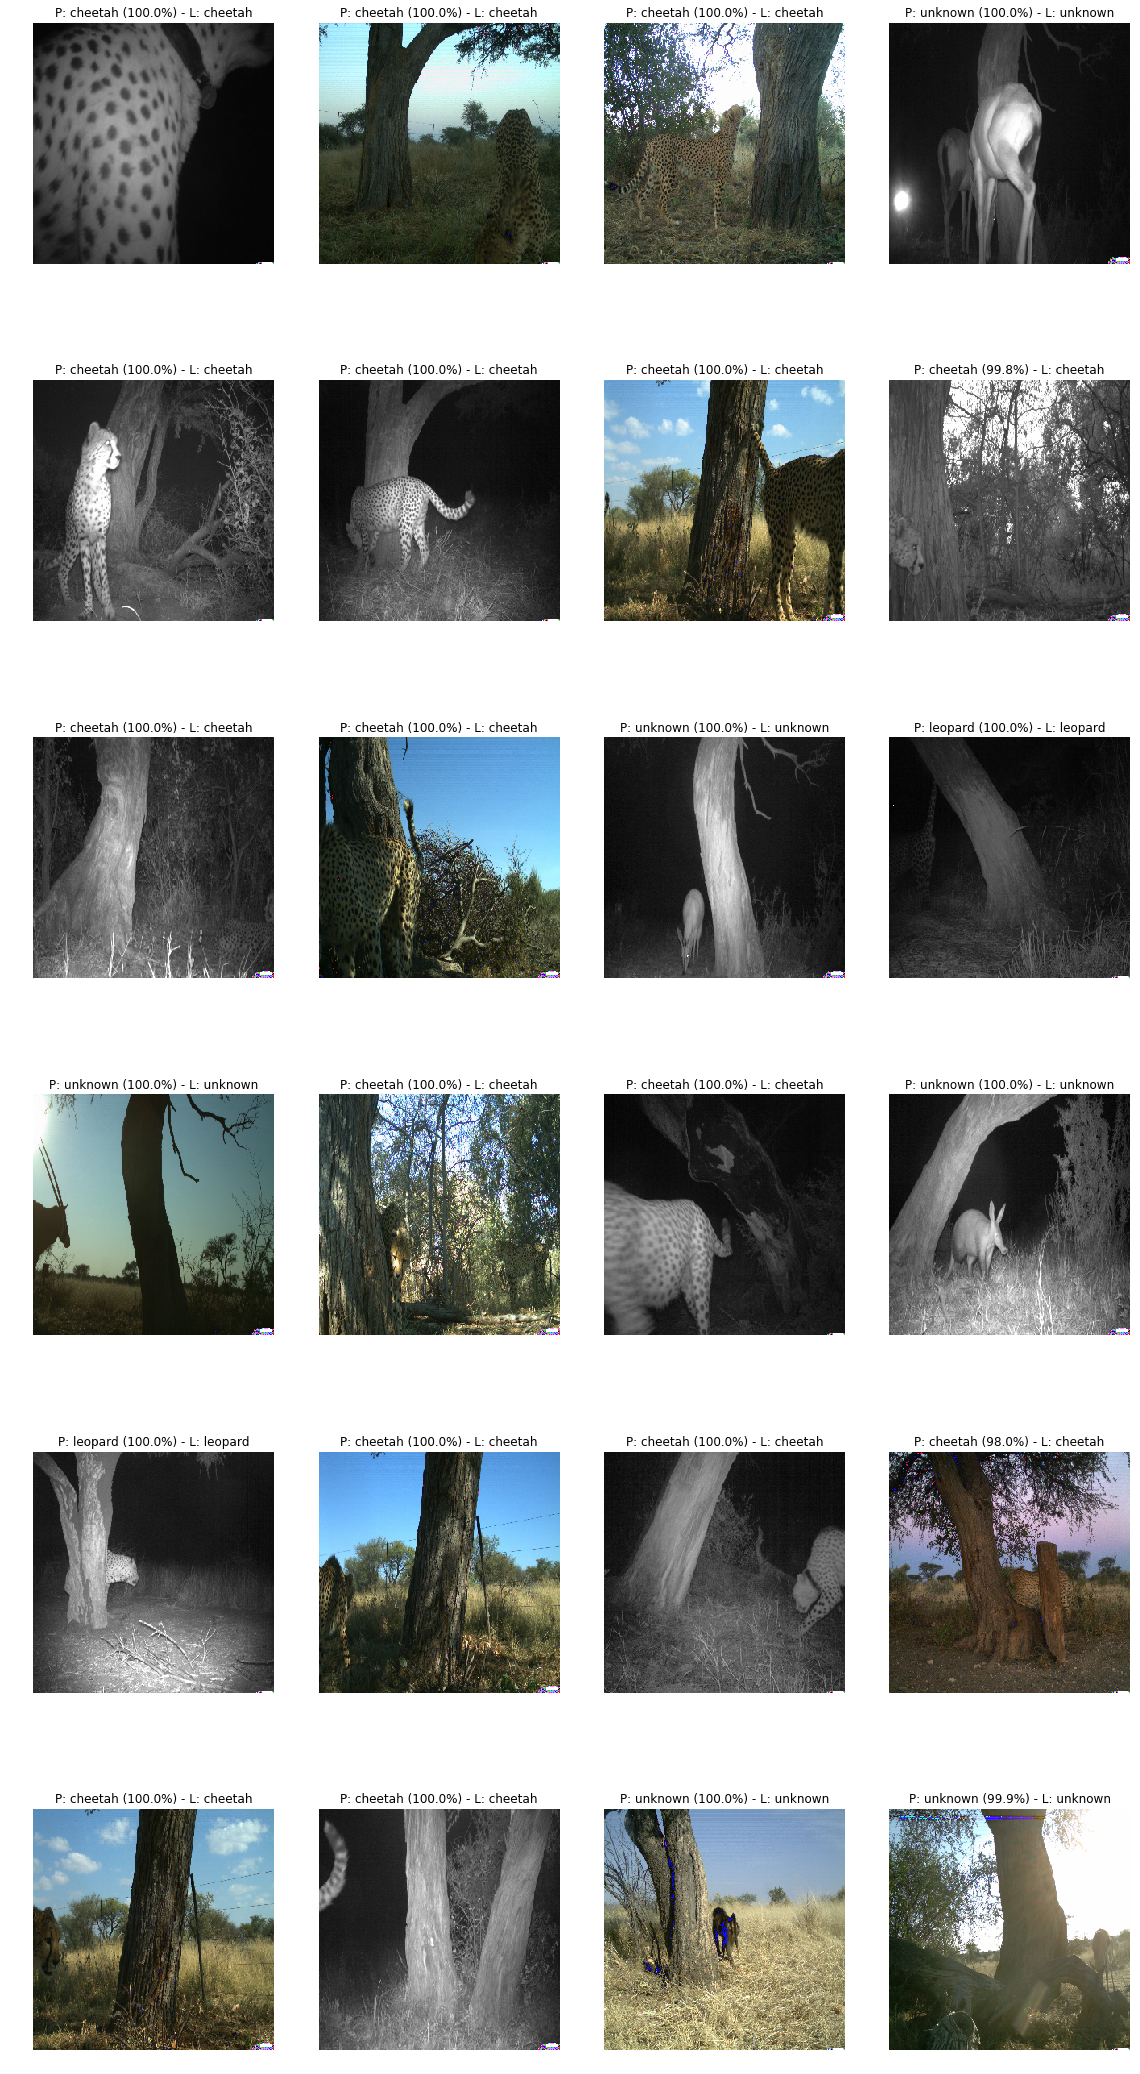

In [19]:
# Visualize model predictions

batch, true_labels = next(val_gen)

fig, axes = plt.subplots(6, 4, figsize=(16, (20 / 4) * 6))
for idx, (image, label, true_label) in enumerate(zip(batch[0][:24], model.predict([batch[0][:24], batch[1][:24]]), true_labels[:24])):
    r, c = divmod(idx, 4)
    axes[r, c].imshow(1 - ((image / 2) + .5) * 255, vmin=0, vmax=255)
    axes[r, c].set_title('P: {} ({:.1f}%) - L: {}'.format(
        izw_classes[label.argmax()],
        label[label.argmax()] * 100,
        izw_classes[true_label.argmax()]))
    axes[r, c].grid('off')
    axes[r, c].set_axis_off()

fig.tight_layout()

---
We store the class probabilities of the predictions in the validation dataframe copy.

In [20]:
val_metadata['predict_probs'] = 0
val_metadata['predict_probs'] = val_metadata['predict_probs'].astype(object)

for event_key, group in val_metadata.groupby('event_key_simple'):
    batch_x = np.zeros((len(group), 299+20, 299+20, 3), dtype=K.floatx())
    batch_t = np.zeros((len(group), ), dtype=K.floatx())
    batch_h = np.zeros((len(group), ), dtype=K.floatx())
    group_iterator = enumerate(zip(group.index, group.set_path, group.ambient_temp, group.hour))
    for i, (file_idx, path, temp, hour) in group_iterator:
        file_path = os.path.join(*([val_data_path] + path.split('/')[-2:]))
        img = load_img(file_path, grayscale=False, target_size=(299+20, 299+20))
        x = img_to_array(img)
        x = val_generator.random_transform(x.astype(K.floatx()))
        x = val_generator.standardize(x)
        batch_x[i] = x
        batch_t[i] = temp
        batch_h[i] = hour
    batch_x = batch_x[:, 10:-10, 10:-10, :]
    batch_x = [preprocess_input(batch_x), np.stack((batch_t, batch_h), axis=1)]
    pred = model.predict_on_batch(batch_x)
    
    for i, (row_index, row) in enumerate(group.iterrows()):
        val_metadata.at[row_index, 'predict_probs'] = pred[i,:]

We can do a preliminary analysis on the single images (ignoring the correlated 3-image events) and estimate our new accuracy, which is also much improved compared to the naive model:

In [21]:
izw_class_arr = np.array(izw_classes)

val_preds = val_metadata['predict_probs'].apply(np.argmax).as_matrix()
val_probs = np.vstack(val_metadata['predict_probs'])
val_labels = val_metadata['label'].apply(lambda x: np.where(x == izw_class_arr)[0][0]).as_matrix()

Accuracy: 98.427%

             precision    recall  f1-score   support

    unknown       0.99      0.97      0.98       543
    cheetah       0.99      0.99      0.99      1475
    leopard       0.89      0.96      0.92       144

avg / total       0.98      0.98      0.98      2162



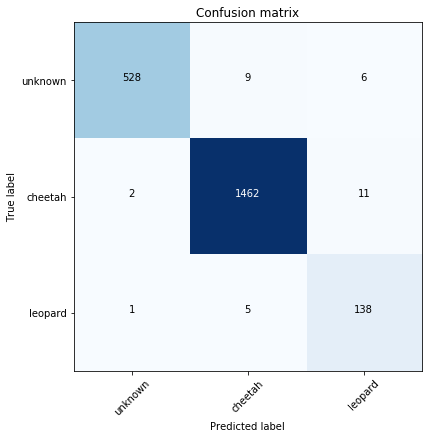

In [22]:
print('Accuracy: {:.3f}%\n'.format(accuracy_score(val_labels, val_preds) * 100))
print(classification_report(val_labels, val_preds, target_names=izw_classes))

label_confusion_matrix(val_labels, val_preds)

In [23]:
cheetah_val_probs = val_probs[:, izw_classes.index('cheetah')]
cheetah_val_labels = val_labels == izw_classes.index('cheetah')

precision, recall, thresholds = precision_recall_curve(cheetah_val_labels, cheetah_val_probs)

(-0.05, 1.05)

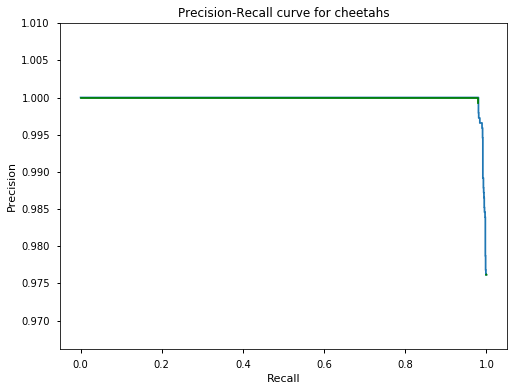

In [24]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.plot(recall[precision > .999], precision[precision > .999], c='green')
plt.plot(recall[recall > .999], precision[recall > .999], c='green')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall curve for cheetahs')
plt.ylim([precision.min()-0.01, precision.max()+0.01])
plt.xlim([-0.05, 1.05])

In [25]:
precision_max_recall = precision[np.where(recall > .999)[0][-1]]
print('Precision for cheetahs for recall > 99.9%: {:.1f}%'.format(precision_max_recall * 100))

Precision for cheetahs for recall > 99.9%: 97.6%


---
# Classification analysis - simple events

Individual images are classified quite well. We now want to explore how series of events can be optimally classified.

We explore three strategies:

- Use the image with the highest probability classification as the label for the 3-image events.
- Sum the class probabilities in the 3-image events and take the highest probabilty. (Amounts to averaging over the images.)
- Label the 3 images separately and majority vote the label, break ties among 3 classes by probability.

First, we explore the prevalence of 3-image events with conflicting predicted labels according the the maximum class probabilities:

In [26]:
def get_event_labels(data_group):
    # count the number of events where we have different labels
    label_counts = np.array([0,0,0,0])
    # count the number of times any of the labels were correct
    correct_label = np.array([0,0,0,0])
    
    event_lens = np.array([0,0,0,0])

    for index, group in data_group:
        group_label = izw_classes.index(group['label'].iloc[0])
        labels = group['predict_probs'].apply(np.argmax).unique()
        label_count = len(labels)
        label_counts[label_count] += 1
        event_lens[label_count] += len(group)
        correct_label[label_count] += 1 if group_label in labels else 0
        
    return label_counts, correct_label, event_lens

label_counts, correct_label, event_lens = get_event_labels(val_metadata.groupby('event_key_simple'))
print("Observed label counts: {}".format(label_counts))
print("Correct label in set:  {}".format(correct_label))
print("Correct label in set:  {}".format(event_lens))

Observed label counts: [  0 738  16   1]
Correct label in set:  [  0 733  16   1]
Correct label in set:  [   0 2111   48    3]


---
### Unique-label event accuracy
Most of the events only have one label, of which almost all are correct. Of the few events which have 2 or even 3 labels, the correct label is at least among the options (which is of course trivially true for the 3 label cases).

We can't do much about the events where all images are mislabeled, but we can look at the confusion matrix for these. It shows that 2 images are false positives (a harmless case) while the others, except 1 missed Leopard, confuse Cheetahs and Leopards. 

Accuracy: 99.322%

             precision    recall  f1-score   support

    unknown     0.9948    0.9896    0.9922       193
    cheetah     0.9960    0.9960    0.9960       498
    leopard     0.9583    0.9787    0.9684        47

avg / total     0.9933    0.9932    0.9932       738



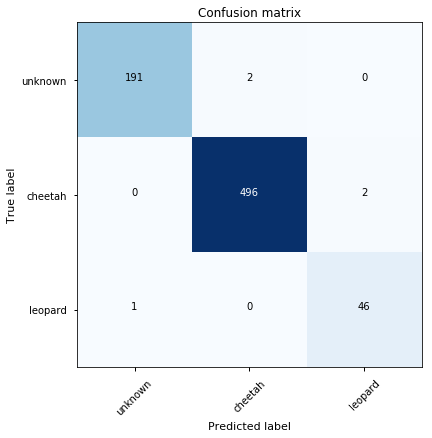

In [27]:
def unique_label_predictions(data_group, normalize_counts = False):
    group_labels, group_preds = [], []
    for index, group in data_group:
        labels = group['predict_probs'].apply(np.argmax).unique()
        group_label = izw_classes.index(group['label'].iloc[0])
        if len(labels) == 1:     
            factor = len(group) if normalize_counts else 1
            group_preds.extend([labels[0]] * factor)
            group_labels.extend([group_label] * factor)
            
    return group_labels, group_preds

group_labels, group_preds = unique_label_predictions(val_metadata.groupby('event_key_simple'))
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels, group_preds) * 100))
print(classification_report(group_labels, group_preds, target_names=izw_classes, digits=4))

label_confusion_matrix(group_labels, group_preds)

Accuracy: 99.479%

             precision    recall  f1-score   support

    unknown     0.9981    0.9923    0.9952       522
    cheetah     0.9972    0.9959    0.9966      1454
    leopard     0.9571    0.9926    0.9745       135

avg / total     0.9949    0.9948    0.9948      2111



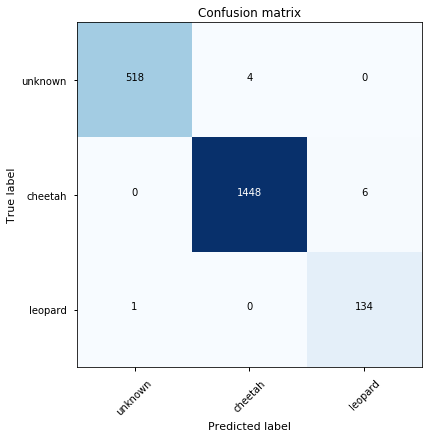

In [28]:
group_labels, group_preds = unique_label_predictions(val_metadata.groupby('event_key_simple'), normalize_counts=True)
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels, group_preds) * 100))
print(classification_report(group_labels, group_preds, target_names=izw_classes, digits=4))

label_confusion_matrix(group_labels, group_preds)

---
### Conflicting-label event accuracy
We now try the labeling strategies (maximum probability vs. sum probabilities) for the muliply labeled cases.

It seems as if the selection based on the maximum class probability for any of the 3 images gives better results.

	=========   Normalized   =========
Accuracy: 88.235%

             precision    recall  f1-score   support

    unknown   1.000000  0.857143  0.923077         7
    cheetah   0.875000  1.000000  0.933333         7
    leopard   0.666667  0.666667  0.666667         3

avg / total   0.889706  0.882353  0.882051        17

Accuracy: 70.588%

             precision    recall  f1-score   support

    unknown   1.000000  0.571429  0.727273        21
    cheetah   0.700000  1.000000  0.823529        21
    leopard   0.333333  0.333333  0.333333         9

avg / total   0.758824  0.705882  0.697389        51



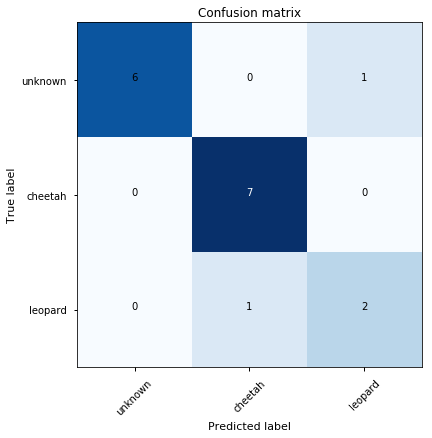

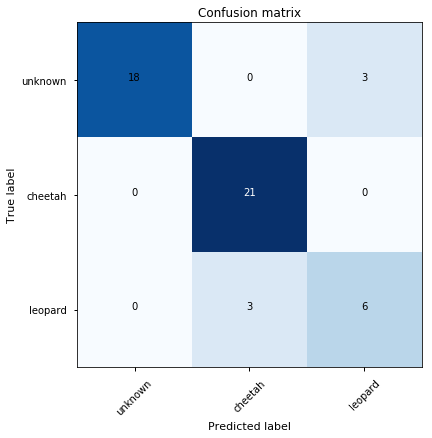

In [29]:
def all_label_predictions(data_group, normalize_counts = False):
    group_labels_all, group_preds_all, group_labels, group_preds1, group_preds2 = [], [], [], [], []
    for index, group in data_group:
        group_probs = np.vstack(group['predict_probs'])
        labels = group['predict_probs'].apply(np.argmax).unique()
        group_label = izw_classes.index(group['label'].iloc[0])
        factor = len(group) if normalize_counts else 1

        if len(labels) > 1:
            group_labels_all.extend([group_label]*factor)
            group_labels.extend([group_label]*factor)
            label1 = np.unravel_index(group_probs.argmax(), group_probs.shape)[1]
            label2 = np.sum(group_probs, axis=0).argmax()
            group_preds_all.extend([label1]*factor)
            group_preds1.extend([label1]*factor)
            group_preds2.extend([label2]*factor)
        else:
            group_labels_all.extend([group_label]*factor)
            group_preds_all.extend([labels[0]]*factor)
            
    return group_labels_all, group_preds_all, group_labels, group_preds1, group_preds2
        
group_labels_all1, group_preds_all1, group_labels, group_preds1, group_preds2 = all_label_predictions(val_metadata.groupby('event_key_simple'), normalize_counts=False)
print('\t=========   Normalized   =========')
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels, group_preds1) * 100))
print(classification_report(group_labels, group_preds1, target_names=izw_classes, digits=6))
label_confusion_matrix(group_labels, group_preds1)

group_labels_all2, group_preds_all2, group_labels, group_preds1, group_preds2 = all_label_predictions(val_metadata.groupby('event_key_simple'), normalize_counts=True)
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels, group_preds2) * 100))
print(classification_report(group_labels, group_preds2, target_names=izw_classes, digits=6))
label_confusion_matrix(group_labels, group_preds1)

---
### Overall event accuracy
The accuracy for the whole dataset is then around 99%, on an event-level resolution.

Even for the individual images in the events, the accuracy is increased due to the conflicting label resolution via maximum event class probability.

Accuracy: 99.073%

             precision    recall  f1-score   support

    unknown       0.99      0.98      0.99       200
    cheetah       0.99      1.00      1.00       505
    leopard       0.94      0.96      0.95        50

avg / total       0.99      0.99      0.99       755



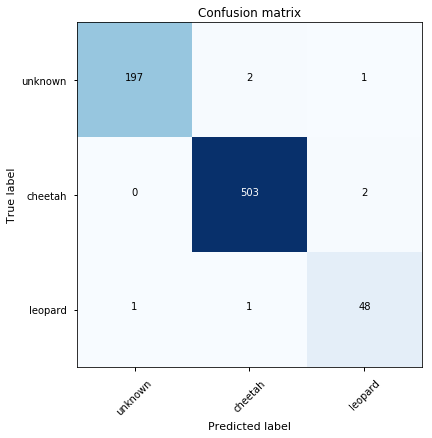

In [30]:
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels_all1, group_preds_all1) * 100))
print(classification_report(group_labels_all1, group_preds_all1, target_names=izw_classes))
label_confusion_matrix(group_labels_all1, group_preds_all1)

Accuracy: 99.214%

             precision    recall  f1-score   support

    unknown       1.00      0.99      0.99       543
    cheetah       1.00      1.00      1.00      1475
    leopard       0.94      0.97      0.96       144

avg / total       0.99      0.99      0.99      2162



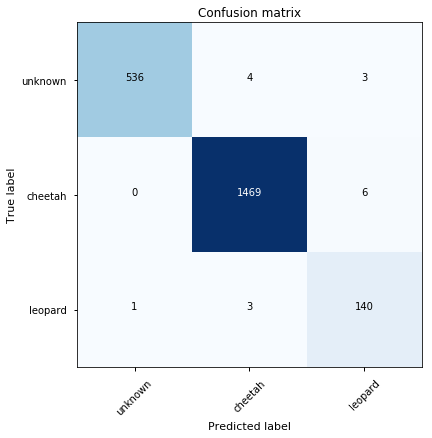

In [31]:
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels_all2, group_preds_all2) * 100))
print(classification_report(group_labels_all2, group_preds_all2, target_names=izw_classes))
label_confusion_matrix(group_labels_all2, group_preds_all2)

---
# Classification analysis - extended events

Exploiting correlations in the 3-image events allowed us to improve the accuracy compared to single-image classification. In the preprocessing phase, we connected 3-image events that occurred in succession (since they likely capture the same extended event).  
We can now try if the longer events let us reduce the error rate further - if an event has a Leopard classification but the events before and after detected a Cheetah, we might be able to correct the Leopard misclassification.

However, we have to be careful with very long events, since it might happen that the presence two different animals really overlapped. (Should check ecological plausibility here.)

For now, we just use the same strategies as for the 3-image events: Classify extended events by the most confident prediction among all images or the sum of all probabilities.

In [32]:
ext_label_counts, ext_correct_label, ext_event_lens = get_event_labels(val_metadata.groupby('event_key'))
print("Observed label counts: {}".format(ext_label_counts))
print("Correct label in set:  {}".format(ext_correct_label))
print("Num. of events in set: {}".format(ext_event_lens))

Observed label counts: [  0 562  16   1]
Correct label in set:  [  0 558  16   1]
Num. of events in set: [   0 2091   68    3]


---
### Unique-label event accuracy

The unique-label accuracy is increased for extended events compared to 3-image events. This is counter-intuitive, since non-conflicting 3-image events could be still unique in larger events.  
But as the table above shows, some unique 3-events were merged into other events that were already conflicting. Among others, 3 Cheetahs that were misclassified as Leopards were moved.

The accuracy increase is thus mostly an artifact of the data here, the interest should mostly lie in how labeling conflicts in extended events are resolved (see below).

Accuracy: 99.617%

             precision    recall  f1-score   support

    unknown     0.9981    0.9923    0.9952       519
    cheetah     0.9972    0.9979    0.9976      1440
    leopard     0.9776    0.9924    0.9850       132

avg / total     0.9962    0.9962    0.9962      2091



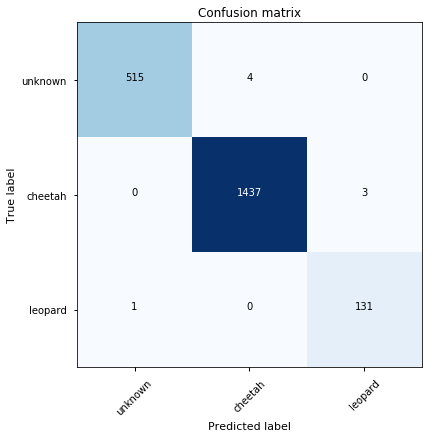

In [33]:
group_labels, group_preds = unique_label_predictions(val_metadata.groupby('event_key'), normalize_counts=True)
print('Accuracy: {:.3f}%\n'.format(accuracy_score(group_labels, group_preds) * 100))
print(classification_report(group_labels, group_preds, target_names=izw_classes, digits=4))

label_confusion_matrix(group_labels, group_preds)

---
### Conflicting-label event accuracy

Again, classifying an event based on its most confident classification for any image gives the best results - even improved from the 3-image event resolution.

In [34]:
ext_group_labels_all, ext_group_preds_all, ext_group_labels, ext_group_preds1, ext_group_preds2 = all_label_predictions(val_metadata.groupby('event_key'), normalize_counts=True)
    
print('Accuracy: {:.3f}%\n'.format(accuracy_score(ext_group_labels, ext_group_preds1) * 100))
print(classification_report(ext_group_labels, ext_group_preds1, target_names=izw_classes))

print('Accuracy: {:.3f}%\n'.format(accuracy_score(ext_group_labels, ext_group_preds2) * 100))
print(classification_report(ext_group_labels, ext_group_preds2, target_names=izw_classes))

Accuracy: 95.775%

             precision    recall  f1-score   support

    unknown       1.00      0.88      0.93        24
    cheetah       1.00      1.00      1.00        35
    leopard       0.80      1.00      0.89        12

avg / total       0.97      0.96      0.96        71

Accuracy: 78.873%

             precision    recall  f1-score   support

    unknown       1.00      0.75      0.86        24
    cheetah       0.83      0.83      0.83        35
    leopard       0.50      0.75      0.60        12

avg / total       0.83      0.79      0.80        71



---
### Overall event accuracy
Overall, using extended events slightly improves upon the 3-event image classification - and both are better than the individual image classification.

HOWEVER: Note that the improvement in accuracy comes mostly from resolving the classification of 3 events (9 images), which confused Leopards and Cheetahs.  
We should not draw overly strong conclusions from such a small sample, but the maximum event class probability mode will be used for event-mislabeling resolution. 


Accuracy: 99.491%

             precision    recall  f1-score   support

    unknown       1.00      0.99      0.99       543
    cheetah       1.00      1.00      1.00      1475
    leopard       0.96      0.99      0.98       144

avg / total       1.00      0.99      0.99      2162



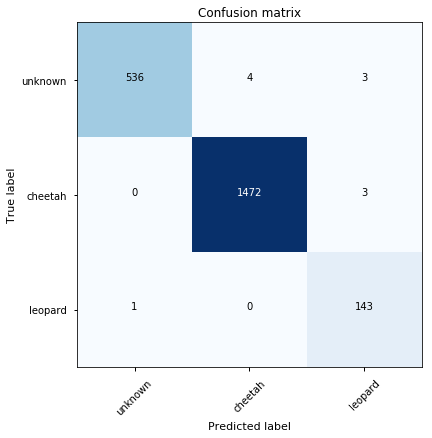

In [35]:
print('Accuracy: {:.3f}%\n'.format(accuracy_score(ext_group_labels_all, ext_group_preds_all) * 100))
print(classification_report(ext_group_labels_all, ext_group_preds_all, target_names=izw_classes))
label_confusion_matrix(ext_group_labels_all, ext_group_preds_all)